In [1]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.5.4.58-cp38-cp38-manylinux2014_x86_64.whl (47.6 MB)


In [315]:

from typing import List
import itertools
import os
import shutil
import uuid
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path
import subprocess
import tempfile
import time

import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

import cv2

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

In [3]:
####################################
# Read dataset
####################################

INPUT = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"

# import heat extremes data
ds = xr.open_mfdataset(INPUT)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [94]:
# ds

In [113]:
####################################
# Contours algotihm
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

# constants for openCV countour finding
SMOOTH_RATIO = 0.005
MIN_AREA = 150
CONVEX = False

# constants derived from the root dataset
LONS = ds.coords['lon']
LATS = ds.coords['lat']


class Contour():
    """A single contour obj. All unit operations are managed here."""
    
    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.name = uuid.uuid4().hex[:6]
        self._area = 0.0
        self._smoothened = np.array([], dtype=np.int32)
        self._projected = np.array([], dtype=np.float64)
        self._center = ()
    
    def __repr__(self):
        return self.name
    
    @property
    def area(self):
        return cv2.contourArea(self.contour)
    
    @property
    def smoothened(self):
        cnt = self.contour
        arc = SMOOTH_RATIO*cv2.arcLength(cnt,True)
        return cv2.approxPolyDP(cnt,arc,True)
    
    @property
    def projected(self):
        squeezed = self.smoothened.squeeze()
        proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in squeezed]
        return np.array(proj).reshape((-1,1,2))
    
    @property
    def center(self):
        M = cv2.moments(self.contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (float(LONS[cX]), float(LATS[cY])) 

    def position_to(self, c2:object)->str:
        """Find the relative position of a Contour obj to another.
        Return if c1 is inside or outside c2, or they intersect."""
        
        f = cv2.pointPolygonTest
        c1 = self.contour.squeeze().astype(float)
        tf = np.array([int((f(c2.contour, x, False))) for x in c1])
        if all(tf==-1):
            return "outside"  
        elif all(tf==1):
            return "inside" 
        else:
            return "intersect" 
    
    def __add__(self, obj2:object):
        """Fuse two countor objects ('bubbles'). Better do this if they 
        intersect or one is enclosed inside the other."""
        
        c1, c2 = self.contour, obj2.contour
        fused = cv2.convexHull(np.vstack([c1, c2]))
        new_obj = self.__class__(fused)
        new_obj.name = self.name
        return new_obj

def find_contours(arr2d: np.array, 
                  convex:bool=False, 
                  min_area:int=150) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),].
    input:  day-slice of a dataset tasmax dataarray
    output: list of contours (np.arrays)"""
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if convex:
        contours = [cv2.convexHull(c) for c in contours]
        
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    for c in contours:
        if c.ndim!=3:
            print(c.shape)
    contours = [Contour(c) for c in contours]
    contours = [c for c in contours if c.area>min_area]
    
    return contours

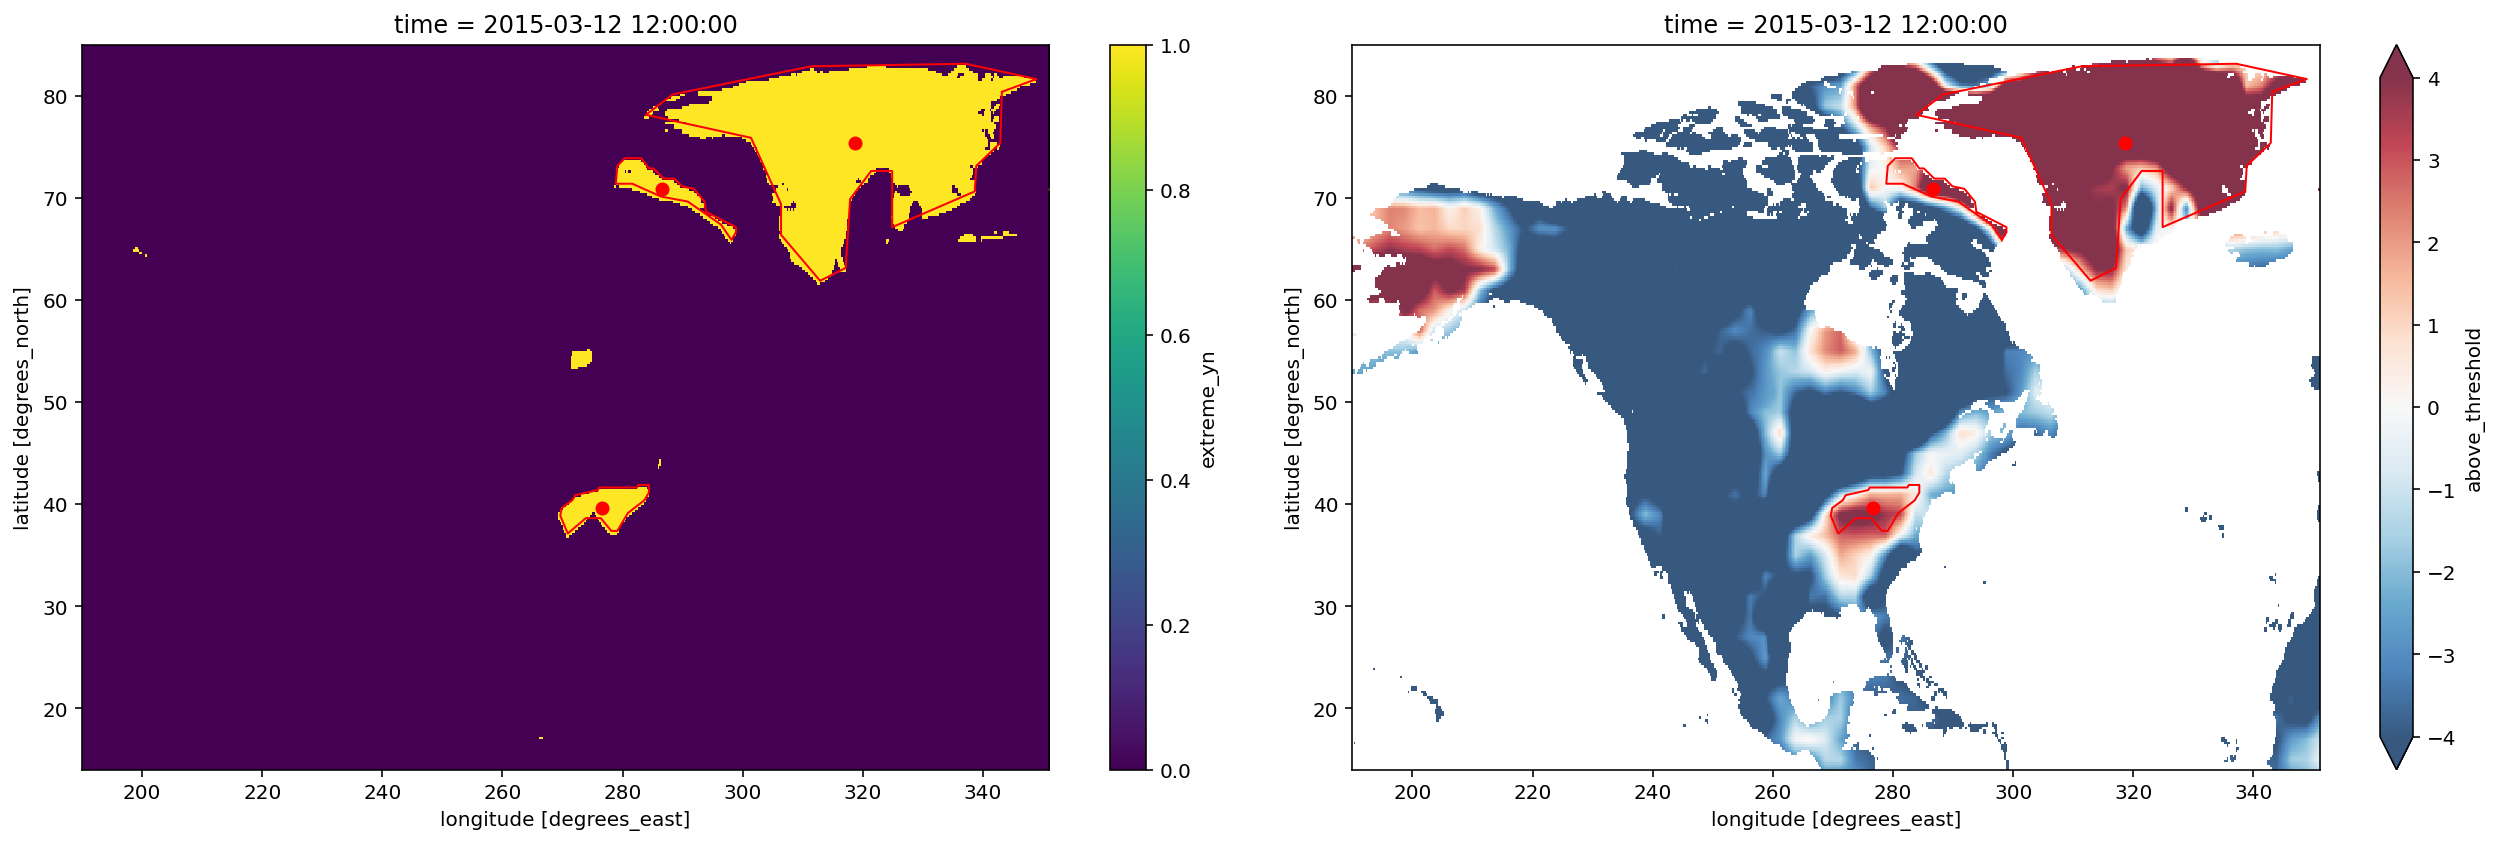

In [114]:
####################################
# Visualize a random day (slice)
####################################

# select the day to plot
idx = 70

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA) 

# add these patches on the plot(s)
patches = [Polygon(c.projected.squeeze(), True) for c in contours]

args = dict(edgecolors=("r",), linewidths=(1,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
[ax1.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]
p = PatchCollection(patches, **args)
ax2.add_collection(p)
[ax2.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]

fig.tight_layout()

In [115]:
%%time
####################################
# Rolling-window contours summation on time axis
####################################

def find_daily_contours(ds:xr.Dataset)->pd.DataFrame:
    """Give a dataset and it will loop through days and
    find all contours per day, if any. This function does ~
    df['contours'].rolling(window=4).sum() """
    
    dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

    all_contours = []
    days = []
    for d in dr:
        day = d.strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        arr2d = extreme.values[0]

        all_contours += [find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA)]
        days += [day]

    df = pd.DataFrame(dict(days=days, contours=all_contours))

    assert len(ds['extreme_yn'])==len(df)
    
    return df
    
df_daily = find_daily_contours(ds)
df_daily

CPU times: user 2.11 s, sys: 798 ms, total: 2.91 s
Wall time: 1.45 s


,days,contours
0,2015-01-01,"[077df0, efd098, 5b15ea, 6b1327]"
1,2015-01-02,"[2c4f65, e4fbca, 74b3aa, 2eb4fc, 925510]"
2,2015-01-03,"[5b731e, 11064c, 6b6d84, 1c92e8, ad8e66, 8dc625]"
3,2015-01-04,"[c02237, 87e577, 458809, 97b78d, 3bc5f4, d26ad..."
4,2015-01-05,"[25590a, 913b85, 19c283, aaf9e4, 24ac30, d471a6]"
...,...,...
360,2015-12-27,"[2bc126, 2c867b, bc0dae]"
361,2015-12-28,"[ad29d5, 551d4e]"
362,2015-12-29,"[be0504, 342bd1, e31e00]"
363,2015-12-30,"[4520a1, f344bc, 5203c4, e60ca1]"


In [174]:
%%time
####################################
# Read dataset
####################################

ROLLING = 4

def collapse(contours:List[Contour]) -> List[Contour]:
    """Recursive func to fuse multiple contour objects, if overlapping."""
    
    if type(contours)==float and pd.isna(contours):
        return []
    
    conts = contours[:] # prevent mutation
    for cnt1, cnt2 in itertools.combinations(conts, 2):
        if cnt1.position_to(cnt2) in ("inside", "intersect"):
            cnt_new = cnt1+cnt2
            conts.remove(cnt1)
            conts.remove(cnt2)
            conts.append(cnt_new)
            return collapse(conts) # recursion
        
    return conts

def rolling_sum(df:pd.DataFrame, window:int)->pd.DataFrame:
    """Provide df with daily contours calculated, and it will df.rolling(w).sum()
    The only reason we can't use pandas is that its .rolling method refuses sum(lists)."""

    for i in range(1, window+1):
        df[f"shift{i}"] = df['contours'].shift(i)
    
    df['rolling_append'] = df.filter(regex=r'contours|shift*', axis=1).dropna().sum(axis=1)
    df['rolling_sum'] = df['rolling_append'].apply(collapse)
    df = df[[c for c in df.columns if "shift" not in c]]
    df = df.drop("rolling_append", axis=1)
    
    assert len(ds['extreme_yn'])==len(df)
    
    return df

df_contours = rolling_sum(df_daily, ROLLING)
df_contours

CPU times: user 1.34 s, sys: 14.1 ms, total: 1.35 s
Wall time: 1.35 s


,days,contours,rolling_sum
0,2015-01-01,"[077df0, efd098, 5b15ea, 6b1327]",[]
1,2015-01-02,"[2c4f65, e4fbca, 74b3aa, 2eb4fc, 925510]",[]
2,2015-01-03,"[5b731e, 11064c, 6b6d84, 1c92e8, ad8e66, 8dc625]",[]
3,2015-01-04,"[c02237, 87e577, 458809, 97b78d, 3bc5f4, d26ad...",[]
4,2015-01-05,"[25590a, 913b85, 19c283, aaf9e4, 24ac30, d471a6]","[19c283, 5b731e, 24ac30, bc7537, 11064c, 6b6d8..."
...,...,...,...
360,2015-12-27,"[2bc126, 2c867b, bc0dae]","[05a44a, 95eddc, a321d7, b6718e]"
361,2015-12-28,"[ad29d5, 551d4e]","[714230, 2bc126, b4b435, 067ad8]"
362,2015-12-29,"[be0504, 342bd1, e31e00]","[714230, 95eddc, 067ad8, bc9d06]"
363,2015-12-30,"[4520a1, f344bc, 5203c4, e60ca1]","[2bc126, 2c867b, 067ad8]"


In [277]:
####################################
# Pipeline to generate fig for each day with contours
####################################

LOCAL_FOLDER = f"CMIP6_images"

def validate(df:pd.DataFrame):
    assert "contours" in df.columns
    assert "rolling_sum" in df.columns
    assert df.index.is_monotonic
    
def plot_contours(df:pd.DataFrame, window:int):  
    
    validate(df)
    
    def add_patches(column:str, _idx:int, color:str, linewidths:int, alpha=1):
        contours = df[column][df.index==_idx].values[0]
        patches = [Polygon(c.projected.squeeze(), True) for c in contours]

        args = dict(edgecolors=(color,), linewidths=(linewidths,), facecolor="none", alpha=alpha)
        
        p = PatchCollection(patches, **args)
        ax1.add_collection(p)
        [ax1.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]
        
        p = PatchCollection(patches, **args)
        ax2.add_collection(p)
        [ax2.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]
    
    for i, idx in enumerate(df.index):

        dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
        day = dr[idx].strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))

        im1 = extreme.squeeze().plot.imshow(ax=ax1, cmap='cividis')
        im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='coolwarm', vmin=4, vmax=-4, alpha=0.8)

        colors = 'r b c w m g y'.split()*100
        for x in range(i+1):
            add_patches('contours', idx-x, colors[i-x], 1.5)
            if x==window:
                add_patches('rolling_sum', idx, 'g', 4, alpha=0.8) 
                break

        fig.tight_layout()
        
        # save image locally
        if not os.path.exists(LOCAL_FOLDER):
            os.mkdir(LOCAL_FOLDER)
        fig.savefig(f"{LOCAL_FOLDER}/{day}.jpg")
        
        plt.close(fig)
        
plot_contours(df_contours, window=ROLLING)
# shutil.rmtree(LOCAL_FOLDER) # to flush all from local

In [ ]:
sas_token = getpass.getpass() 

In [278]:
####################################
# Upload a file to Azure
####################################

URL_PREFIX = 'https://nasanex30analysis.blob.core.windows.net'
BLOB_FOLDER = "cmip6/contours"
    
def toAzure(fn:str, sas_token:str):
    
    sas_url = f"{URL_PREFIX}/{BLOB_FOLDER}/{fn}?{sas_token}"
    blob_client = BlobClient.from_blob_url(sas_url)
    
    with open(fn, "rb") as f:
        try:
            blob_client.upload_blob(f)
            print("uploaded to Azure.")
        except HttpResponseError as err:
            raise HttpResponseError(err, "make sure to give write permissions!") 
        except ResourceExistsError:
            raise ResourceExistsError(fn)
            

In [325]:
%%time
####################################
# Compile a video from images
####################################

def as_video(files:List[str], fn_out:str)->None:
    
    h,w,_ = cv2.imread(files[0]).shape

    with tempfile.TemporaryFile() as f:

        fp = f"{f.name}.avi"
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video = cv2.VideoWriter(fp, fourcc, 10, (w,h))

        for fn in files:
            img = cv2.imread(fn)
            video.write(img)

        video.release()
        os.rename(fp, 'out.avi')
        time.sleep(2)

    fn_in = 'out.avi'
    cmd = f"ffmpeg -i '{fn_in}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{fn_out}'"

    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)  


files = sorted([str(p) for p in Path(LOCAL_FOLDER).rglob("*.jpg")])

as_video(files, 'out.mp4')

CPU times: user 5.65 s, sys: 53.2 ms, total: 5.71 s
Wall time: 12.5 s


CompletedProcess(args="ffmpeg -i 'out.avi' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 'out.mp4'", returncode=0)

In [ ]:
####################################
# Upload images and the video to Azure
####################################

for fn in files:
    toAzure(fn, sas_token)
    
toAzure('out.mp4', sas_token)